In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.corpus import state_union, stopwords

# Unit 4 Capstone:
## An Exploration of Supervised and Unsupervised Learning for NLP 

In this notebook, we'll dig into a corpus of State of the Union addresses with the goal of classifing the texts using a combination of supervised and unsupervised learning techniques.  The corpus comes from nltk and contains 65 State of the Union addresses from ten different US presidents (Harry S. Truman through George W. Bush). 

__Sections:__

[Text Processing](#section1)<br>
[Unsupervised Feature Generation](#section2)<br>
[Supervised Learning Models](#section3)<br>
[Comparing Supervised and Unsupervised Learning for NLP Applications](#section4)

<a id='section1'></a>
## Text Processing

The first step is to get each speech for the corpus.  We'll create a list to store each file name and then create a loop to break each file into sentence level documents.  

In [3]:
# Make list of individual file ids
file_ids = state_union.fileids()

# Create blank labels list to populate
labels = []

# Iterate through list of files pulling out President name & year
for file in file_ids:
    
    # label president for each text.  Splice to extract name, remove non-alpha characters for 
    # occassions when a President gave more than one State of the Union address in the same year.
    president = re.sub("[^a-zA-Z]", '', file[5:-4])
       
    # Append to labels list
    labels.append([file, president])

# Create blank lists to populate with sentence level data
sent_list = []
pres_list = []

# Iterate through each State of the Union, create sentence level documents, maintain President
# and year information for each sentence
for i in range(len(labels)):
    sents = state_union.sents(labels[i][0]) #get sentences from document
    joined_sents = [(' '.join(sent), labels[i][1]) for sent in sents]
    
    # write out to individual lists for easier text processing
    for i in range(len(joined_sents)): 
        sent_list.append(joined_sents[i][0]) 
        pres_list.append(joined_sents[i][1])  

print(len(sent_list))
sent_list[:5]

17930


["PRESIDENT HARRY S . TRUMAN ' S ADDRESS BEFORE A JOINT SESSION OF THE CONGRESS",
 'April 16 , 1945',
 'Mr . Speaker , Mr . President , Members of the Congress : It is with a heavy heart that I stand before you , my friends and colleagues , in the Congress of the United States .',
 'Only yesterday , we laid to rest the mortal remains of our beloved President , Franklin Delano Roosevelt .',
 'At a time like this , words are inadequate .']

We've created 17,930 sentence level text documents. Looking at a few example sentences, we see this first sentence of each speech acts as a title identifying the address.  Let's clean up the documents to get rid of these sentences as well as punctuation and numeric values.  We'll deal with capitalization in the [unsupervised feature generation section](#section2).

In [4]:
# Create list to hold cleaned up sentences
sent_list_clean = []

# Iterate through sentence list, removing punctuation, numeric values,
# frequently occuring word 'applause' that acts like a stop word in this 
# context, and sentences with all capital letters that represent title 
# information for each speech.
for sent in sent_list:
    sent = re.sub("[^a-zA-Z]", ' ', sent) #remove numeric and punctuation
    if sent == sent.upper():              #removes ALL CAPS header sentences
        sent = ""                         #replace with blank
    sent_list_clean.append(sent)

# Inspect cleaned sentences
print(len(sent_list_clean))
sent_list_clean[:4]

17930


['',
 'April          ',
 'Mr   Speaker   Mr   President   Members of the Congress   It is with a heavy heart that I stand before you   my friends and colleagues   in the Congress of the United States  ',
 'Only yesterday   we laid to rest the mortal remains of our beloved President   Franklin Delano Roosevelt  ']

Now that we have our cleaned up documents, let's tokenize the sentences into words and get the lemmas. 

In [5]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

# Create list to hold lemmatized sentences
lemma_sents = []

# Tokenize, get lemmas, and rejoin back to sentence level doc
for sent in sent_list_clean:
    words = word_tokenize(sent)                                 
    word_lemma = [lemmatizer.lemmatize(word) for word in words] 
    sent_lemma = ' '.join(word_lemma)                           
    lemma_sents.append(sent_lemma)

# Inspect results
lemma_sents[:5]

['',
 'April',
 'Mr Speaker Mr President Members of the Congress It is with a heavy heart that I stand before you my friend and colleague in the Congress of the United States',
 'Only yesterday we laid to rest the mortal remains of our beloved President Franklin Delano Roosevelt',
 'At a time like this word are inadequate']

The text is almost ready to go.  Let's send it to a dataframe, remove all the blank lines, and see how things look.  From there, we're ready to move on to some unsupervised feature generation.

In [6]:
# Send to data frame
df = pd.DataFrame()
df['sent'] = lemma_sents
df['president'] = pres_list

# Remove blank documents 
df = df[df.sent!=""]
df.head()

,sent,president
1,April,Truman
2,Mr Speaker Mr President Members of the Congres...,Truman
3,Only yesterday we laid to rest the mortal rema...,Truman
4,At a time like this word are inadequate,Truman
5,The most eloquent tribute would be a reverent ...,Truman


<a id='section2'></a>
## Unsupervised Feature Generation

In the section above, we cleaned up our text and processed it into sentence level documents.  In this section, we'll explore two techniques for generating unsupervised features:
* Tf-idf
* Latent Semantic Analysis

First, let's take a look at class balance and then split the dataframe into a training and testing sets.  We'll save 25% for testing our supervised models later on.   

In [138]:
# Examine class balance.  Predominantly Clinton, Eisenhower, GWBush, Reagan, and Truman
df.groupby('president').count()/df['sent'].count()

,sent
president,
Bush,0.068645
Carter,0.032546
Clinton,0.175419
Eisenhower,0.129280
Ford,0.040273
GWBush,0.121270
Johnson,0.097749
Kennedy,0.040160
Nixon,0.046308


In [7]:
from sklearn.model_selection import train_test_split

# Split data frame, reserving 25% for validation

df_train, df_test = train_test_split(df,
                                    stratify=df['president'], #maintain class balance between splits
                                    test_size=0.25,
                                    random_state=42)

# Examine shapes
print(df_train.shape)
print(df_test.shape)

(13296, 2)
(4433, 2)


### Technique #1: Tf-idf Vector
The first techique is to create term frequency-inverse document frequency (tf-idf) vectors for each word.  The following components make up the tf-idf value:

* **Document frequency** - How many documents the word appears in.  More common words will have a higher document frequency.
* **Inverse document frequency** - Takes the log (base 2) of the ratio between the total documents to the document frequency.  More frequeny words are penalized whereas less common words become more influential.
* **Term frequency** - How many times the term appears in a document.  In this case, it's how many times a word appears in a sentence.
* **Tf-idf** - Product of the term frequency multiplied by the inverse document frequency.  Largest tf-idf scores will represent words that occur a lot in a small number of sentences, and the lowest for a word that occurs in many sentences.  The benefit of tf-idf is that you can identify unique words that may help distinguish text documents from one another.

We can easily calculate our tf-idf vector matrix using TfidfVectorizer.  In the process, we'll also do a bit more text cleaning by removing stop words and standardizing everything to lowercase.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', #filter out stopwords
                             lowercase=True,       #convert all to lowercase
                             min_df=2,             #use words appearing at least twice per document
                             max_df=0.5,           #drop words that occur in more than half of the documents
                             use_idf=True,
                             smooth_idf=True,
                             norm='l2'
                             )

# Specify data to vectorize
X_train = df_train['sent']
X_test = df_test['sent']

# Vectorize training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Fit test data to vector
X_test_tfidf = vectorizer.transform(X_test)

# Examine shapes 
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(13296, 5967)
(4433, 5967)


Once we calculate our tf-idf matrices, we can calculate the average tf-idf for each word.  Looking at both the training and test data sets, we see the same top ten weighted words.  Perhaps unsuprisingly, they're generic words I'd expect to see in a State of the Union address. 

In [9]:
# Calculate weights on training data
weights = np.asarray(X_train_tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'avg_weight': weights})
print("Train:\n", weights_df.sort_values(by='avg_weight', ascending=False).head(10))

# Calculate weights on test data
weights = np.asarray(X_test_tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'avg_weight': weights})
print("\nTest:\n", weights_df.sort_values(by='avg_weight', ascending=False).head(10))

Train:
       avg_weight        word
299     0.022281    applause
5945    0.018338        year
3783    0.014657      people
2439    0.013625          ha
5905    0.013314       world
242     0.013177     america
3467    0.013005      nation
2367    0.011454  government
1044    0.011220    congress
3513    0.011217         new

Test:
       avg_weight        word
299     0.024733    applause
5945    0.021633        year
3783    0.015646      people
2439    0.014644          ha
5905    0.014433       world
242     0.013274     america
2367    0.012511  government
3467    0.012503      nation
3513    0.012015         new
1044    0.011547    congress


### Technique #2: Latent Semantic Analysis using Singular Value Decomposition

We can take our tf-idf vector matrix one step further and perform latent semantic analysis (LSA) on the words in an attempt to gain semantic information.  LSA is performed through a dimensionality reduction technique called singluar value decompositin (SVD).  SVD is applied to a tf-idf vector matrix and the resulting components represent clusters of words that presumably reflect topics within the corpus.  

Here we'll reduce our tf-idf feature space to 10% of its orignial value and take a look at some of the components.

In [18]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

# Reduce feature space to ~10% of original
svd = TruncatedSVD(600)

# Make pipeline to run svd and normalize results
lsa_pipe = make_pipeline(svd, Normalizer())

# Fit with training data, transform test data
X_train_lsa = lsa_pipe.fit_transform(X_train_tfidf)
X_test_lsa = lsa_pipe.transform(X_test_tfidf)

# Examine variance captured in reduced feature space
variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by components:', total_variance*100)

sent_by_component = pd.DataFrame(X_train_lsa, index=X_train)

# Look at values from first 5 components
for i in range(6):
    print('Component {}:'.format(i))
    print(sent_by_component.loc[:, i].sort_values(ascending=False)[:5]) 

Percent variance captured by components: 55.49882017265345
Component 0:
sent
Applause    0.999784
Applause    0.999784
Applause    0.999784
Applause    0.999784
Applause    0.999784
Name: 0, dtype: float64
Component 1:
sent
But my colleague this I believe With the help of God who ha blessed this land so richly with the cooperation of the Congress and with the support of the American people we can and we will make the year a year of unprecedented progress toward our goal of building a structure of lasting peace in the world and a new prosperity without war in the United States of America                                                                                                                                                                                                                                                                                                                                                                                                                       

Using SVC, we were able to reduce the feature space to approximately 10% of it's original size (5,965 down to 600 columns) and still capture 55% of the variation.  Not too bad.  We could increase the feature space size to try and capture more variation, but my local computing environment is maxed out, so we'll stick with the current setup.

What about the components?  Looking at the first 5 sentences of the first 6 components, we get the following semantic information:

* Component 0 - The word 'applause'.  This is a corpus specific stop word that could be removed from the documents.
* Component 1 - Longer statements containing positive sentiments about prosperity in America, world peace.
* Component 2 - Statements referencing the word 'year'.
* Component 3 - Statements involving America and it's relationship to the world, particularly involving peace.  Similar to component 0.
* Component 4 - Statements around 'let's do', a collective call to action.
* Component 5 - The phrase 'we the people'

<a id='section3'></a>
## Supervised Learning

Now let's try out our tf-idf and LSA feature sets on a few models to see if one performs better than the other at predicting the document source.  In this case, the source is one of ten presidents. Because we have ten target classes, we'll need to use classification models that support multiclass output.  

Let's look at the performance of the following models:
* Random Forest Classifier
* Logistic Regression
* Support Vector Classifier

To streamline the workflow, let's write a function that will test each model on both the tf-idf and LSA features and then produce a confusion matrix for each test case.

In [132]:
# Import models 
from sklearn.ensemble import RandomForestClassifier                          
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC   

# Import evaluation metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

# Specify target variables
Y_train = df_train['president']
Y_test = df_test['president']

In [126]:
# Set up funtion to run models on both feature sets and generate accuracy scores and confusion matrices
def run_model(clf):
    
    #************ TFIDF Feature Inputs ***************
    X_train = X_train_tfidf
    X_test = X_test_tfidf
    
    # Fit with tfidf features
    clf.fit(X_train, Y_train)
    
    # Predict outcomes for confusion matrix
    Y_pred_tf = clf.fit(X_train_tfidf, Y_train).predict(X_test_tfidf)
    
    # Get results
    print('TF-IDF Features:')
    print('Train accuracy:', clf.score(X_train, Y_train))
    print('Test accuracy:', clf.score(X_test, Y_test))
    print('---------------------------------------------')

    # ************ LSA Feature Inputs *******************
    X_train = X_train_lsa
    X_test = X_test_lsa
    
    # Refit with lsa features
    clf.fit(X_train, Y_train)
    
    # Predict outcomes for confusion matrix
    Y_pred_lsa = clf.fit(X_train_lsa, Y_train).predict(X_test_lsa)
    
    print('LSA Features:')
    print('Train accuracy:', clf.score(X_train, Y_train))
    print('Test accuracy:', clf.score(X_test, Y_test))
    
    # ************ Generate Confusion Matrices ****************
    
    # Specify text labels
    labels = sorted(Y_test.unique())
    
    # Make tfidf confusion matrix, send to df
    cm_tf = confusion_matrix(Y_test, Y_pred_tf)
    df_cm_tf = pd.DataFrame(cm_tf, labels, labels)
  
    # Make lsa confusion matrix, send to df
    cm_lsa = confusion_matrix(Y_test, Y_pred_lsa)
    df_cm_lsa = pd.DataFrame(cm_lsa, labels, labels)
    
    # Setup plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

    
    # ******************** Plot *************************
    
    # Create confustion matrix heatmaps 
    sns.heatmap(df_cm_tf, ax=ax1)
    sns.heatmap(df_cm_lsa, ax=ax2)

    # Set title and axis
    ax1.set_title('Tf-idf Confusion Matrix')
    ax2.set_title('LSA Confusion Matrix')

    ax1.set_ylabel('Actual')
    ax1.set_xlabel('Predicted')
    ax2.set_xlabel('Predicted')

    plt.tight_layout()
    plt.show()

#### Random Forest

TF-IDF Features:
Train accuracy: 0.27812876052948254
Test accuracy: 0.2434017595307918
---------------------------------------------
LSA Features:
Train accuracy: 0.30212093862815886
Test accuracy: 0.24836453868711933


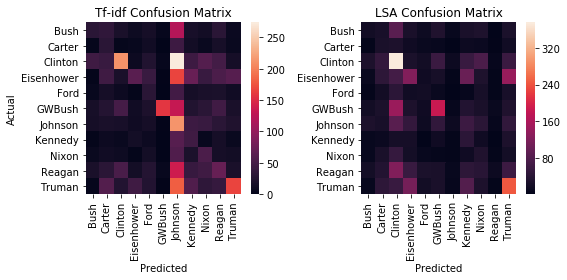

In [129]:
# Specify the classifier
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=3,
                             random_state=42,
                             class_weight='balanced' 
                            )   

# Run model
run_model(clf)

Both feature sets performed about the same in terms of overall accuracy.  Looking at the confusion matrices, we see the tf-idf features predominately predicted Johnson as the document source.  The LSA features performed well at correctly identifying Clinton, GWBush, and Truman, but poorly for all other cases.  Despite setting the __class_balance__ parameter to __'balanced'__, prediction accuracies generally follow the class imbalance present in the data.

A bonus to using the Random Forest Classifier with tf-idf features is the ability to look at feature importances.  Let's take a look at what the top ten most important words were when training the model.

In [15]:
# Use model to get feature importance
feat_importance = clf.fit(X_train_tfidf, Y_train).feature_importances_
features = vectorizer.get_feature_names()

importance_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'importance': feat_importance})
importance_df.sort_values(by='importance', ascending=False).head(10)

,importance,word
299,0.052127,applause
818,0.030735,child
5789,0.021028,war
2142,0.020488,fiscal
5348,0.018744,terrorist
3092,0.016225,legislation
4786,0.015754,shall
1980,0.015015,expenditure
5423,0.014583,tonight
2910,0.014188,iraq


Again, we see 'applause' as the most important word.  This could be throwing off the model because it's effectively a corpus specific stop word.

#### Logistic Regression

TF-IDF Features:
Train accuracy: 0.6225180505415162
Test accuracy: 0.42837807353936386
---------------------------------------------
LSA Features:
Train accuracy: 0.4858604091456077
Test accuracy: 0.40130836905030454


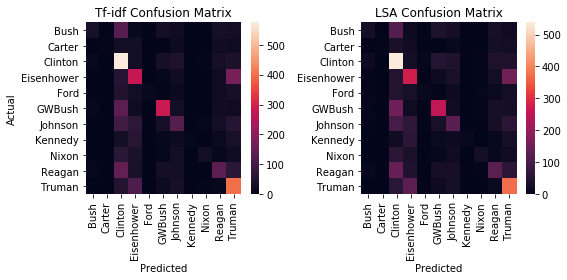

In [130]:
# Specify and run model
clf = LogisticRegression()
run_model(clf)

Logistic regression performed much better overall, although accuracy again generally followed the class imbalance.  Both feature sets worked well at correctly predicting Clinton, and to a lesser extent, Eisenhower, GWBush, and Truman. The tf-idf feature set was more prone to overfitting.

#### Support Vector Machine 

TF-IDF Features:
Train accuracy: 0.17539109506618533
Test accuracy: 0.17550191743740132
---------------------------------------------
LSA Features:
Train accuracy: 0.17539109506618533
Test accuracy: 0.17550191743740132


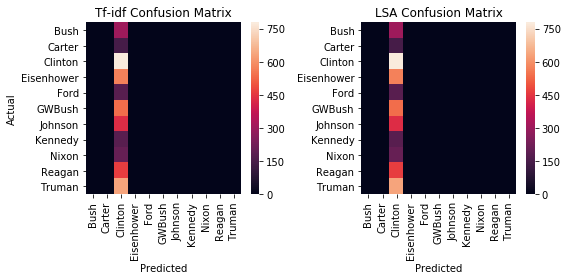

In [131]:
# Specify and run model
clf = SVC()
run_model(clf)

Yikes.  The support vector machine classifier worked terribly for both feature sets and took a very long time to run.  The model latched on exclusively to Clinton as the document source.  Model accuracy merely reprents the percentage of documents that came from Clinton.

<a id='section4'></a>
## Comparing Supervised and Unsupervised Learning for NLP Applications

Based on the three models above, it's clear more work could be done to make a more accurate classifier.  For starters, we could removing corpus specific stop words and address the class imbalance that's manifesting itself our model accuracies.  But the purpose here wasn't to build the best classifier possible (although that would have been a good perk).  Instead, we explored how supervised and unsupervised methods could be applied to natural language processing applications.  

Here's a summary of what we learned:

__Unsupervised:__
* Tf-Idf can be used to detect unique identifier words
* SVD can identify corpus specific stop words (i.e. 'applause'), as well as common phrases (i.e. 'we the people')
* SVD clusters the tf-idf matrix into general themes and sentiments present in the documents.  Sometimes these clusters are meaningful and can shed light on common sentiments.
* We didn't use similarity comparison here because it didn't make much sense for our document size.  However, if the document size was larger, say the full text body for each address, running a similarity analysis could be quite informative.  For example, we could compare the similarity of different presidents, or look at how similarity changes within a president's term.

__Supervised:__
* The utility of supervised methods is more limited and should be used for text classification purposes.  Depending on the model used, additional insights could be gained by looking at feature importance.